# Mean Reversion Quality Screener

Screen a universe of FX pairs for mean-reversion quality using a battery of statistical metrics:

| Metric | Mean-Reverting Signal |
|---|---|
| **Hurst Exponent** (R/S) | H < 0.5 |
| **ADF Test** | Low p-value → stationary |
| **OU Regression** | Negative b, low p-value |
| **Half-Life** | Finite, positive |
| **Variance Ratio** VR(q) | VR < 1 |
| **Mean-Crossing Frequency** | High → oscillatory |

In [1]:
import numpy as np
import pandas as pd
import MetaTrader5 as mt5
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from IPython.display import display

from metalib.indicators import calculate_half_life_nb, retrieve_number_of_crossings_nb

# ---- MT5 connection ----
if not mt5.initialize():
    raise RuntimeError(f"MT5 initialization failed: {mt5.last_error()}")
print(f"MT5 connected  \u2014  build {mt5.version()}")


def pull_close_prices(symbol: str, timeframe: int, num_bars: int = 50_000) -> pd.Series:
    """Pull close prices from MT5, with broker suffix fallback."""
    for suffix in ["", ".a", ".b", ".pro", "_SB"]:
        sym = symbol + suffix
        rates = mt5.copy_rates_from_pos(sym, timeframe, 0, num_bars)
        if rates is not None and len(rates) > 0:
            df = pd.DataFrame(rates)
            df['time'] = pd.to_datetime(df['time'], unit='s')
            df.set_index('time', inplace=True)
            return df['close']
    raise ValueError(f"No data returned for {symbol} (tried suffixes)")

MT5 connected  —  build (500, 5572, '30 Jan 2026')


In [10]:
# ---- Configuration ----
SYMBOLS = [
    "EURUSD", "GBPUSD", "USDJPY", "USDCHF", "AUDUSD", "USDCAD", "NZDUSD",
    "EURGBP", "EURJPY", "GBPJPY", "AUDCHF", "AUDNZD", "EURCHF", "AUDCHF",
    "GBPCHF", "NZDCHF", "CADCHF", "NZDCAD", "AUDCAD", "GBPAUD",
]

TIMEFRAME      = mt5.TIMEFRAME_H1
NUM_BARS       = 50_000          # ~5.7 years of H1 data
ROLLING_WINDOW = 500             # for z-score normalisation in OU regression
VR_LAG         = 5               # variance ratio lag parameter

In [11]:
# ---- Metric Functions ----

def compute_hurst(log_prices: np.ndarray, max_lag: int = 200) -> float:
    """Hurst exponent via Rescaled Range (R/S) method."""
    ts = np.asarray(log_prices, dtype=np.float64)
    lags = range(2, max_lag + 1)
    rs_values = []
    for lag in lags:
        # split into non-overlapping blocks
        n_blocks = len(ts) // lag
        if n_blocks < 1:
            break
        rs_block = []
        for i in range(n_blocks):
            block = ts[i * lag:(i + 1) * lag]
            mean_b = np.mean(block)
            cumdev = np.cumsum(block - mean_b)
            R = np.max(cumdev) - np.min(cumdev)
            S = np.std(block, ddof=1)
            if S > 0:
                rs_block.append(R / S)
        if rs_block:
            rs_values.append((np.log(lag), np.log(np.mean(rs_block))))

    if len(rs_values) < 2:
        return np.nan
    rs_arr = np.array(rs_values)
    # OLS: log(R/S) = H * log(lag) + c
    slope, _ = np.polyfit(rs_arr[:, 0], rs_arr[:, 1], 1)
    return slope


def compute_adf(log_prices: np.ndarray) -> dict:
    """ADF test on log-prices. Returns test stat and p-value."""
    result = adfuller(log_prices, autolag='AIC')
    return {'adf_stat': result[0], 'adf_pvalue': result[1]}


def compute_ou_regression(log_prices: pd.Series, rolling_window: int) -> dict:
    """OLS OU regression on rolling z-score: dX = a + b*X_lag.
    Returns R², b coefficient, b p-value, and half-life."""
    rolling_mu = log_prices.rolling(rolling_window).mean()
    rolling_sigma = log_prices.rolling(rolling_window).std()
    X = ((log_prices - rolling_mu) / rolling_sigma).dropna()

    dX = X.diff().dropna()
    X_lag = X.shift(1).reindex(dX.index)

    model = sm.OLS(dX, sm.add_constant(X_lag)).fit()
    b = model.params.iloc[1]

    if b < 0:
        half_life = -np.log(2) / np.log(1 + b)
    else:
        half_life = np.nan

    return {
        'ou_r2': model.rsquared,
        'ou_b': b,
        'ou_b_pvalue': model.pvalues.iloc[1],
        'ou_half_life': half_life,
    }


def compute_variance_ratio(log_returns: np.ndarray, lag: int) -> float:
    """Lo-MacKinlay Variance Ratio VR(q). VR < 1 implies mean reversion."""
    returns = np.asarray(log_returns, dtype=np.float64)
    n = len(returns)
    if n < lag + 1:
        return np.nan

    # variance of 1-period returns
    var_1 = np.var(returns, ddof=1)
    if var_1 == 0:
        return np.nan

    # variance of q-period returns (overlapping)
    cumret = np.cumsum(returns)
    q_returns = cumret[lag:] - cumret[:-lag]
    var_q = np.var(q_returns, ddof=1)

    return var_q / (lag * var_1)


def compute_crossing_freq(prices: np.ndarray) -> float:
    """Mean-crossing frequency normalised by series length."""
    n_crossings = retrieve_number_of_crossings_nb(prices)
    return n_crossings / len(prices)

In [15]:
# ---- Run Screener Loop ----
results = []
closes = dict()
for i, symbol in enumerate(SYMBOLS, 1):
    print(f"[{i:2d}/{len(SYMBOLS)}] {symbol} ... ", end="")
    try:
        close = pull_close_prices(symbol, TIMEFRAME, NUM_BARS)
        closes[symbol] = close
        log_prices = np.log(close)
        log_returns = np.diff(log_prices.values)

        hurst = compute_hurst(log_prices.values)
        adf = compute_adf(log_prices.values)
        ou = compute_ou_regression(log_prices, ROLLING_WINDOW)
        # half-life from numba OU fit (on raw prices)
        hl_nb = calculate_half_life_nb(close.values.astype(np.float64))
        vr = compute_variance_ratio(log_returns, VR_LAG)
        cross_freq = compute_crossing_freq(close.values.astype(np.float64))

        row = {
            'Symbol': symbol,
            'Hurst': round(hurst, 4),
            'ADF Stat': round(adf['adf_stat'], 4),
            'ADF p-value': round(adf['adf_pvalue'], 6),
            'OU R\u00b2': round(ou['ou_r2'], 6),
            'OU b': round(ou['ou_b'], 6),
            'OU b p-value': round(ou['ou_b_pvalue'], 6),
            'Half-Life (OU)': round(ou['ou_half_life'], 1) if np.isfinite(ou['ou_half_life']) else np.nan,
            'Half-Life (NB)': round(hl_nb, 1) if np.isfinite(hl_nb) else np.nan,
            'Variance Ratio': round(vr, 4),
            'Crossing Freq': round(cross_freq, 4),
        }
        results.append(row)
        print(f"OK  (H={hurst:.3f}, ADF p={adf['adf_pvalue']:.4f}, HL={ou['ou_half_life']:.0f})")

    except Exception as e:
        print(f"FAILED \u2014 {e}")

df_results = pd.DataFrame(results)
print(f"\nScreener complete: {len(results)}/{len(SYMBOLS)} symbols processed.")

[ 1/20] EURUSD ... OK  (H=1.017, ADF p=0.1368, HL=117)
[ 2/20] GBPUSD ... OK  (H=1.015, ADF p=0.0434, HL=123)
[ 3/20] USDJPY ... OK  (H=1.013, ADF p=0.8844, HL=132)
[ 4/20] USDCHF ... OK  (H=1.014, ADF p=0.8708, HL=117)
[ 5/20] AUDUSD ... OK  (H=1.009, ADF p=0.0566, HL=118)
[ 6/20] USDCAD ... OK  (H=1.012, ADF p=0.0487, HL=106)
[ 7/20] NZDUSD ... OK  (H=1.015, ADF p=0.1539, HL=127)
[ 8/20] EURGBP ... OK  (H=1.014, ADF p=0.0064, HL=96)
[ 9/20] EURJPY ... OK  (H=1.010, ADF p=0.9743, HL=114)
[10/20] GBPJPY ... OK  (H=1.012, ADF p=0.9330, HL=122)
[11/20] AUDCHF ... OK  (H=1.005, ADF p=0.6947, HL=101)
[12/20] AUDNZD ... OK  (H=1.014, ADF p=0.3757, HL=107)
[13/20] EURCHF ... OK  (H=1.009, ADF p=0.7894, HL=85)
[14/20] AUDCHF ... OK  (H=1.005, ADF p=0.6947, HL=101)
[15/20] GBPCHF ... OK  (H=1.012, ADF p=0.5493, HL=101)
[16/20] NZDCHF ... OK  (H=1.008, ADF p=0.9120, HL=101)
[17/20] CADCHF ... OK  (H=1.010, ADF p=0.9400, HL=93)
[18/20] NZDCAD ... OK  (H=1.011, ADF p=0.1006, HL=110)
[19/20] AUDCA

In [13]:
# ---- Summary Table (sorted by Hurst ascending = most mean-reverting first) ----
df_sorted = df_results.sort_values('Hurst', ascending=True).reset_index(drop=True)


def color_hurst(val):
    if val < 0.45:
        return 'background-color: #c6efce; color: #006100'  # green
    elif val > 0.55:
        return 'background-color: #ffc7ce; color: #9c0006'  # red
    return ''


def color_adf_p(val):
    if val < 0.05:
        return 'background-color: #c6efce; color: #006100'
    elif val > 0.10:
        return 'background-color: #ffc7ce; color: #9c0006'
    return ''


def color_vr(val):
    if val < 0.95:
        return 'background-color: #c6efce; color: #006100'
    elif val > 1.05:
        return 'background-color: #ffc7ce; color: #9c0006'
    return ''


def color_ou_b(val):
    if val < -0.005:
        return 'background-color: #c6efce; color: #006100'
    elif val > 0:
        return 'background-color: #ffc7ce; color: #9c0006'
    return ''


styled = (
    df_sorted.style
    .map(color_hurst, subset=['Hurst'])
    .map(color_adf_p, subset=['ADF p-value'])
    .map(color_vr, subset=['Variance Ratio'])
    .map(color_ou_b, subset=['OU b'])
    .format(precision=4)
    .set_caption('Mean Reversion Quality Screening (sorted by Hurst \u2191)')
)
display(styled)

,Symbol,Hurst,ADF Stat,ADF p-value,OU R²,OU b,OU b p-value,Half-Life (OU),Half-Life (NB),Variance Ratio,Crossing Freq
0,AUDCHF,1.0050,-1.1543,0.6929,0.0034,-0.0068,0.0000,101.7000,8219.1000,0.9364,0.0024
1,AUDCHF,1.0050,-1.1543,0.6929,0.0034,-0.0068,0.0000,101.7000,8219.1000,0.9364,0.0024
2,AUDCAD,1.0069,-3.0025,0.0347,0.0036,-0.0071,0.0000,97.2000,1532.5000,0.9011,0.0062
3,NZDCHF,1.0078,-0.4002,0.9101,0.0034,-0.0068,0.0000,101.4000,16544.8000,0.9107,0.0025
4,GBPAUD,1.0080,-2.3893,0.1448,0.0034,-0.0067,0.0000,102.6000,2621.5000,0.9230,0.0038
5,AUDUSD,1.0087,-2.8659,0.0495,0.0029,-0.0059,0.0000,117.8000,2283.5000,0.9582,0.0048
6,EURCHF,1.0092,-0.8643,0.7995,0.0041,-0.0082,0.0000,84.7000,14416.5000,0.8885,0.0013
7,EURJPY,1.0099,0.1954,0.9720,0.0030,-0.0061,0.0000,114.1000,nan,0.9707,0.0028
8,CADCHF,1.0108,-0.1757,0.9414,0.0037,-0.0074,0.0000,93.7000,17960.6000,0.9200,0.0039
9,NZDCAD,1.0115,-2.5645,0.1006,0.0031,-0.0063,0.0000,110.3000,2292.4000,0.9096,0.0050


In [ ]:
# ---- Visualizations ----
df_plot = df_sorted.copy()

# 1) Horizontal bar chart: Hurst exponent per symbol
fig_hurst = go.Figure()
colors = ['#2ca02c' if h < 0.5 else '#d62728' for h in df_plot['Hurst']]
fig_hurst.add_trace(go.Bar(
    y=df_plot['Symbol'], x=df_plot['Hurst'],
    orientation='h', marker_color=colors,
    text=df_plot['Hurst'].round(3), textposition='outside',
))
fig_hurst.add_vline(x=0.5, line_dash='dash', line_color='grey', annotation_text='H=0.5')
fig_hurst.update_layout(
    title='Hurst Exponent by Symbol (lower = more mean-reverting)',
    xaxis_title='Hurst Exponent', yaxis_title='Symbol',
    height=600, yaxis=dict(autorange='reversed'),
)
fig_hurst.show()

# 2) Scatter: Hurst vs Half-Life coloured by ADF p-value
df_scatter = df_plot.dropna(subset=['Half-Life (OU)'])
fig_scatter = px.scatter(
    df_scatter, x='Hurst', y='Half-Life (OU)',
    color='ADF p-value', text='Symbol',
    color_continuous_scale='RdYlGn_r',
    title='Hurst vs Half-Life (colour = ADF p-value, lower = better)',
)
fig_scatter.update_traces(textposition='top center', marker=dict(size=12))
fig_scatter.add_vline(x=0.5, line_dash='dash', line_color='grey')
fig_scatter.update_layout(height=500)
fig_scatter.show()

# 3) Heatmap: normalised metrics for visual ranking
metric_cols = ['Hurst', 'ADF p-value', 'OU b', 'Half-Life (OU)', 'Variance Ratio', 'Crossing Freq']
df_heat = df_plot.set_index('Symbol')[metric_cols].copy()
# Normalise 0-1 per column
df_norm = (df_heat - df_heat.min()) / (df_heat.max() - df_heat.min())
# For crossing freq, invert so that higher = greener (more MR)
df_norm['Crossing Freq'] = 1 - df_norm['Crossing Freq']

fig_heat = go.Figure(data=go.Heatmap(
    z=df_norm.values,
    x=df_norm.columns.tolist(),
    y=df_norm.index.tolist(),
    colorscale='RdYlGn_r',
    text=df_heat.round(3).values,
    texttemplate='%{text}',
    hovertemplate='%{y} | %{x}: %{text}<extra></extra>',
))
fig_heat.update_layout(
    title='Normalised Metric Heatmap (lower/greener = more mean-reverting, except Crossing Freq)',
    height=600, yaxis=dict(autorange='reversed'),
)
fig_heat.show()

In [ ]:
# ---- Multi-Timeframe Comparison for Top 5 Mean-Reverting Assets ----
TIMEFRAMES_MTF = {
    'M15': mt5.TIMEFRAME_M15,
    'H1':  mt5.TIMEFRAME_H1,
    'H4':  mt5.TIMEFRAME_H4,
    'D1':  mt5.TIMEFRAME_D1,
}

top5 = df_sorted['Symbol'].head(5).tolist()
print(f"Top 5 most mean-reverting: {top5}\n")

mtf_results = []

for symbol in top5:
    for tf_name, tf_val in TIMEFRAMES_MTF.items():
        print(f"  {symbol} / {tf_name} ... ", end="")
        try:
            close = pull_close_prices(symbol, tf_val, NUM_BARS)
            log_prices = np.log(close)
            log_returns = np.diff(log_prices.values)

            hurst = compute_hurst(log_prices.values)
            adf = compute_adf(log_prices.values)
            ou = compute_ou_regression(log_prices, ROLLING_WINDOW)
            vr = compute_variance_ratio(log_returns, VR_LAG)
            cross_freq = compute_crossing_freq(close.values.astype(np.float64))

            mtf_results.append({
                'Symbol': symbol,
                'Timeframe': tf_name,
                'Bars': len(close),
                'Hurst': round(hurst, 4),
                'ADF p-value': round(adf['adf_pvalue'], 6),
                'OU b': round(ou['ou_b'], 6),
                'Half-Life': round(ou['ou_half_life'], 1) if np.isfinite(ou['ou_half_life']) else np.nan,
                'Var. Ratio': round(vr, 4),
                'Cross. Freq': round(cross_freq, 4),
            })
            print(f"OK  (H={hurst:.3f})")
        except Exception as e:
            print(f"FAILED \u2014 {e}")

df_mtf = pd.DataFrame(mtf_results)
print(f"\nMulti-timeframe scan complete.")

# Display per symbol
for symbol in top5:
    subset = df_mtf[df_mtf['Symbol'] == symbol]
    if len(subset) > 0:
        print(f"\n{'=' * 60}")
        print(f"  {symbol}")
        print(f"{'=' * 60}")
        display(subset.set_index('Timeframe'))

# Hurst across timeframes for top 5
fig_mtf = px.line(
    df_mtf, x='Timeframe', y='Hurst', color='Symbol',
    markers=True, title='Hurst Exponent Across Timeframes (Top 5)',
)
fig_mtf.add_hline(y=0.5, line_dash='dash', line_color='grey', annotation_text='H=0.5')
fig_mtf.update_layout(height=450)
fig_mtf.show()

mt5.shutdown()
print("\nMT5 connection closed.")

In [14]:
df_results

,Symbol,Hurst,ADF Stat,ADF p-value,OU R²,OU b,OU b p-value,Half-Life (OU),Half-Life (NB),Variance Ratio,Crossing Freq
0,EURUSD,1.0165,-2.4479,0.128660,0.002969,-0.005923,0.0,116.7,3234.0,0.9586,0.0036
1,GBPUSD,1.0147,-2.9504,0.039793,0.002825,-0.005631,0.0,122.8,2159.2,0.9512,0.0059
2,USDJPY,1.0136,-0.5854,0.874257,0.002614,-0.005242,0.0,131.9,32597.4,1.0064,0.0002
3,USDCHF,1.0142,-0.5672,0.878227,0.002952,-0.005901,0.0,117.1,13628.7,0.9423,0.0053
4,AUDUSD,1.0087,-2.8659,0.049463,0.002943,-0.005868,0.0,117.8,2283.5,0.9582,0.0048
5,USDCAD,1.0125,-2.8717,0.048744,0.003261,-0.006511,0.0,106.1,2284.5,0.9573,0.0059
6,NZDUSD,1.0148,-2.3583,0.153856,0.002713,-0.005424,0.0,127.4,3396.7,0.9523,0.0036
7,EURGBP,1.0143,-3.5534,0.006718,0.003599,-0.007195,0.0,96.0,1094.9,0.9390,0.0070
8,EURJPY,1.0099,0.1954,0.972002,0.003020,-0.006058,0.0,114.1,NaN,0.9707,0.0028
9,GBPJPY,1.0116,-0.2447,0.932977,0.002830,-0.005685,0.0,121.6,108042.7,0.9598,0.0021


<Axes: xlabel='time'>

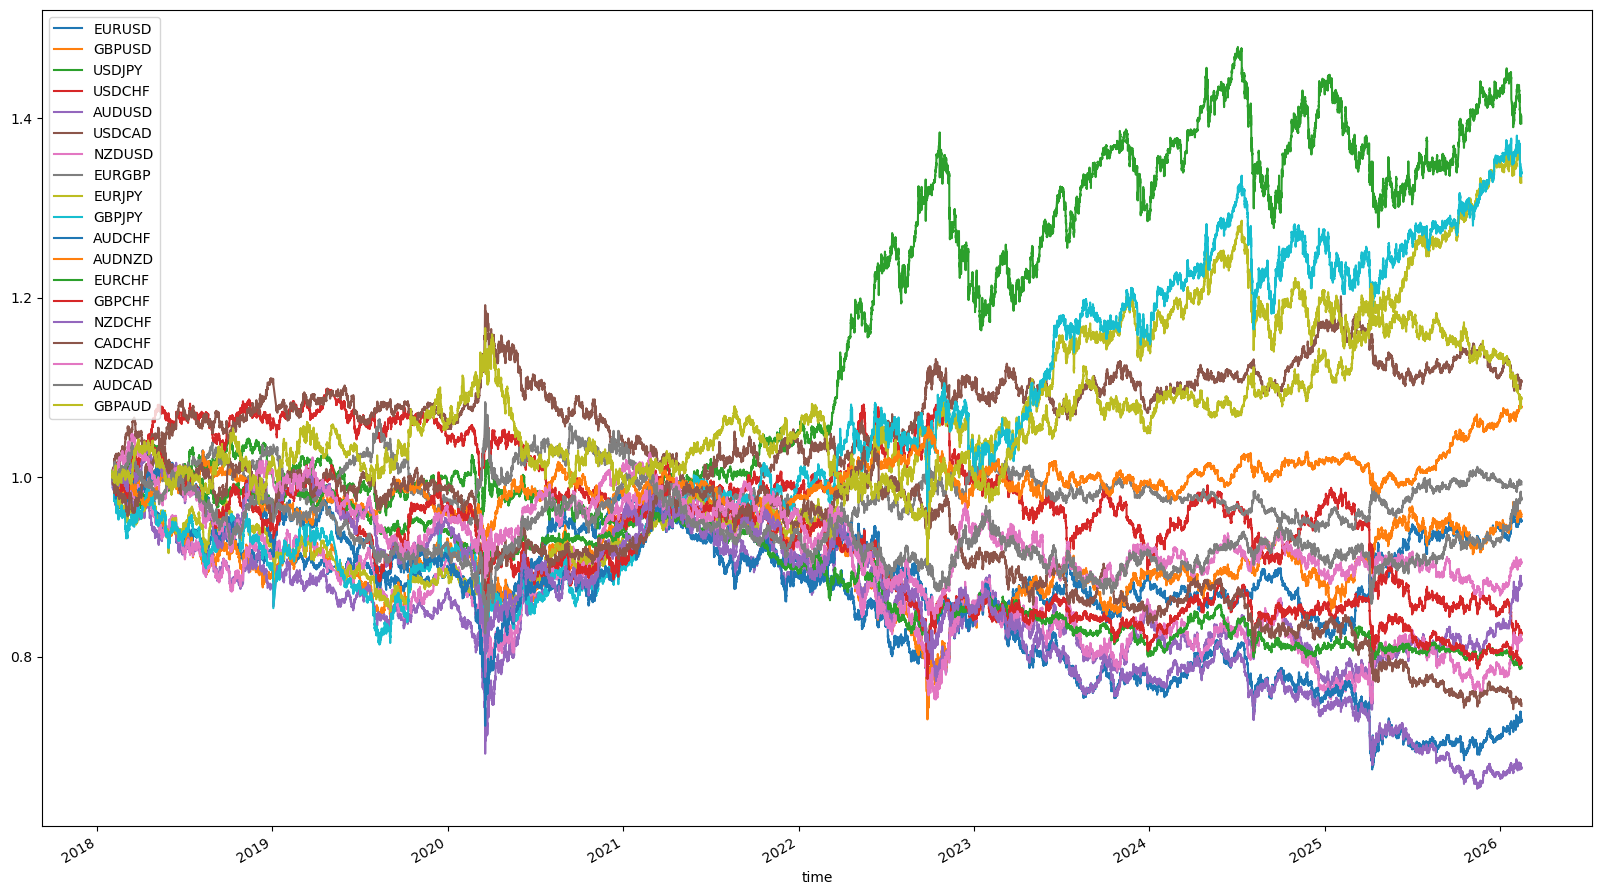

In [20]:
closes_df = pd.DataFrame(closes).dropna()
(closes_df/closes_df.iloc[0]).plot(figsize=(20,12))